In [1]:
import json
import pandas as pd
import optuna as op
import covasim as cv
import seaborn as sns
import matplotlib.pyplot as plt
from util import data, calibration, interventions

sns.set_context('notebook')
sns.set_style('whitegrid')

n_trials = 200

def plot_best(study, n_runs=30, figsize=(18, 8)):
    initial_params = {'pop_infected': study.best_params['pop_infected'], **default_params}
    intervs = interventions.Interventions(df['date'].iloc[0], **study.best_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=n_runs)
    msim.mean()
    msim.plot(
        list(cols) + ['n_infectious', 'n_susceptible'],
        fig_args={'figsize': figsize},
        scatter_args={'s': 5},
        plot_args={'lw': 2},
        interval=45
    )

Covasim 2.0.3 (2021-03-11) — © 2021 by IDM


# Simulator Calibration

## Dataset & Default Parameters

As a first step, we retrieve the historical data about the evolution of the pandemic in Italy from the official [github repository](https://github.com/pcm-dpc/COVID-19/) of the  italian ministry, from which we keep just the records related to the region *Emilia-Romagna*.

> In our simulation, we are using 40k agents with a scaling factor of 10, for a total of 400k simulated people (roughly the population of the city of Bologna). Thus, when loading the data, we need to rescale them from the 4.46 million of people living in the region to our 400k population.

In the end, the extracted columns are:
* the daily number of *tests*, which will be used in the respective intervention
* the number of *severe cases* and *critical cases* at each day
* the cumulative number of *diagnosed* cases, i.e., the people who are known to be positive
* the cumulative number of *deaths*

In [2]:
pop_size = 400e3
pop_scale = 10
cols = ['n_severe', 'n_critical', 'cum_diagnoses', 'cum_deaths']
df = data.get_regional_data(scaling_factor=4.46e6/pop_size)

In [0]:
default_params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df['date'].iloc[0],
    end_day=df['date'].iloc[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    n_beds_hosp=pop_size * 370.4 / 100e3,
    n_beds_icu=pop_size * 14.46 / 100e3,
    quar_period=14,
    verbose=0
)

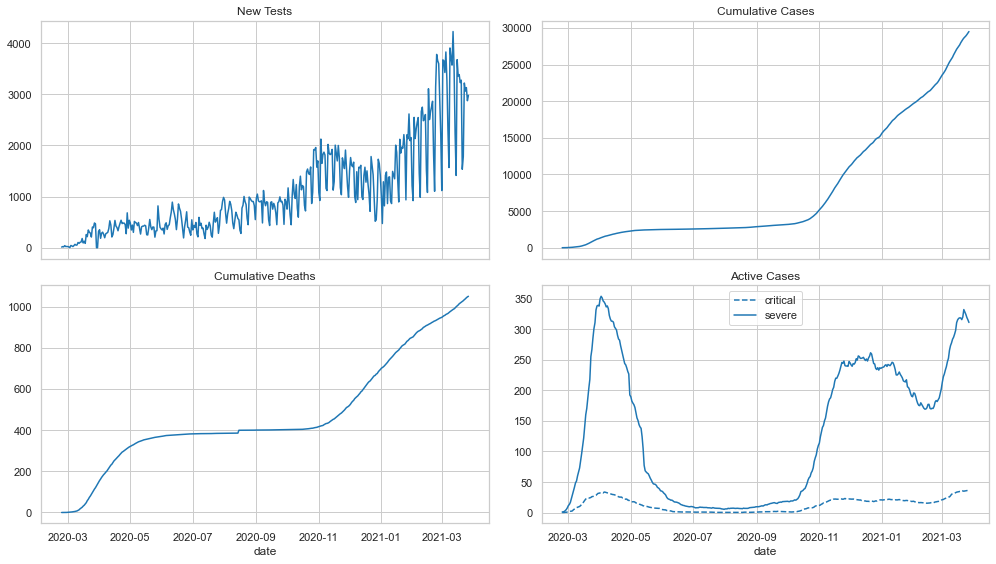

In [3]:
_, axes = plt.subplots(2, 2, figsize=(14, 8), sharex='all')
sns.lineplot(data=df, x='date', y='new_tests', ax=axes[0, 0]).set(title='New Tests', ylabel='')
sns.lineplot(data=df, x='date', y='cum_diagnoses', ax=axes[0, 1]).set(title='Cumulative Cases', ylabel='')
sns.lineplot(data=df, x='date', y='cum_deaths', ax=axes[1, 0]).set(title='Cumulative Deaths', ylabel='')
sns.lineplot(data=df, x='date', y='n_critical', label='critical', color='#1f77b4', linestyle='--', ax=axes[1, 1])
sns.lineplot(data=df, x='date', y='n_severe', label='severe', ax=axes[1, 1]).set(title='Active Cases', ylabel='')
plt.tight_layout()

## Calibration #1: An Initial Approach

In this first approach, we want to learn the parameters for the *six interventions* that we put in our model, plus an initial parameter for the *number of initial infected individuals*. These parameters are:
1. the *contact tracing probability* and *contact tracing delay* for the `work` and `school` layers
  * we supposed them to be almost equal, thus we decided to learn a single parameter for both of them
  * the probability for the `household` layer is 100%, with no delay, while that for the `casual` layer is 0%
2. the relative number of *work contacts* in yellow, orange, and red zone
3. the relative number of *school contacts* in yellow and orange zone
  * this value is fixed to 0% during summer period and red zone
4. the relative number of *casual contacts* in yellow, orange, and red zone
5. the absolute number of *imported cases* at the beginning of the simulation and in yellow, orange, and red zone
  * the number of imported cases during the summer period is the same one of the beginning
6. the absolute *beta* per symptomatic contact at the beginning of the simulation, during the late spring/summer period, and during the subsequent fall/winter period until today
  * this value is the result of both behavioural and environmental factors such as social distancing norms, masks, climate, variants, etc. 

We define our parameters using Optuna's method *suggest_\<type\>*, keeping the bounds as large as possible. These parameters are then passed to our util function to extract the correct list of interventions, which is eventually passed to a *Sim* object from which we calculate the final loss leveraging the default *compute_fit* method from covasim, using as ground truth the *severe* and *critical* columns only.

In [5]:
def objective(trial):
    # define learnable parameters
    initial_params = dict(pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2), **default_params)
    intervention_params = dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0),                         # CONTACT TRACING
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0),                        #
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0),     # SMART WORKING
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0),     #
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0),           #
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0), # SCHOOLS CLOSED
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0), #
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0), # LOCKDOWN INTERACTIONS
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0), #
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0),       #
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0),                    # IMPORTED CASES
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0),                #
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0),                 #
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0),                       #
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2),                           # BETA CHANGE
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2),                       #
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2)                        #
    )
    # define and run simulations, then return loss
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    sim.run()
    return sim.compute_fit(keys=['n_severe', 'n_critical'], weights={'n_severe': 1, 'n_critical': 1}).mismatch

We are now ready to start the optimization phase:
* firstly, we create a *study* object from optuna
* secondly, we call its *optimize* method, to which we pass
   * the routine to compute the objective function based on the selected values
   * another argument that indicates how many trials to run (200 in our case)

In [ ]:
study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

[I 2021-03-27 18:38:02,187] A new study created in memory with name: no-name-a150f2c6-4a0a-4c18-aa5d-cdf67ac452d7


Once we have the results, we are able to inspect them. In order to do so, we get some statistics on the top 10% of the tried configurations in order to see how confident is the optimizer about each investigated parameter.

In [ ]:
calibration.inspect_study(study, top=0.1)[1]

Finally, we can plot the evolution (averaged over 30 runs) of the pandemic curves, i.e., number of *severe* and *critical* cases, and the number of the cumulative *diagnosed* and *dead* individuals, along with their respective ground truths. Additionally, the curves of *infectious* individuals and remaining *susceptibles* are plotted as well.

In [ ]:
plot_best(study)

## Calibration #2: Death Column & Viral Load

While somehow able to catch the trend, the optimizer did not do a great job, in particular for the death column. Thus, from now on we will include this column as well in the set of ground truths to be optimized.

Additionally, we let the optimizer learn a new set of parameters involving the viral load of the virus.

> Ideally, this should allow the optimizer to fit all the three curves by giving them the correct scale. Moreover, as the viral load could have change during time depending on the season and other factors, we leave the degree of freedom to set these parameters for each of our *three macro-steps* (initial, summer, and winter periods), for a total of 12 new parameters.

Again, we define the calibration parameters...

In [ ]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0),
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0),
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0),
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0),
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0),
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0),
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0),
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0),
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0),
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0),
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2),
        init_symp=trial.suggest_float('init_symp', 0.0, 10.0),
        init_sev=trial.suggest_float('init_sev', 0.0, 10.0),
        init_crit=trial.suggest_float('init_crit', 0.0, 10.0),
        init_death=trial.suggest_float('init_death', 0.0, 10.0),
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2),
        summer_symp=trial.suggest_float('summer_symp', 0.0, 10.0),
        summer_sev=trial.suggest_float('summer_sev', 0.0, 10.0),
        summer_crit=trial.suggest_float('summer_crit', 0.0, 10.0),
        summer_death=trial.suggest_float('summer_death', 0.0, 10.0),
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2),
        winter_symp=trial.suggest_float('winter_symp', 0.0, 10.0),
        winter_sev=trial.suggest_float('winter_sev', 0.0, 10.0),
        winter_crit=trial.suggest_float('winter_crit', 0.0, 10.0),
        winter_death=trial.suggest_float('winter_death', 0.0, 10.0)
    )

... we define the objective function and the study, then run the optimization phase...

In [ ]:
def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    sim.run()
    keys = ['n_severe', 'n_critical', 'cum_deaths']
    return sim.compute_fit(keys=keys, weights={k: 1 for k in keys}).mismatch

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

... inspect the results...

In [ ]:
calibration.inspect_study(study, top=0.1)[1]

... and finally we plot the best result.

In [ ]:
plot_best(study)

## Calibration #3: Multi-Sim, Steps & Diagnosed Column

The previous approach had many flaws that we will now try to resolve.

1. the `objective` function is computed as the sum of the mismatches on a single run, which may lead to the exploration of wrong areas of the loss function due to the inner stochastic nature of covasim
  * in order to balance the efficiency and effectiveness, from now on we will average the results of 3 runs
  
2. as some parameters are more coarse-grained than other, we introduce the `step` and `log` parameters of optuna both to reduce the search space to discrete values instead of uniform ones and to guide the search of nearby parameters:
  * to each *probability* parameter will be assigned a step of 0.01
  * to each *absolute* parameter will be assigned a step of 0.1 (except for *pop_infected*)
  * to each *beta* will be assigned no step, being it an extremely fine-grained parameter
  * to each *viral load* parameter will be assigned no step, but a log-uniform search
  
3. the simulator, while trying to fit the summer period, in order to keep the number of cases low while being able to be prepared for the second wave, gets stuck on configurations with a high summer beta and a low summer symptomatic probability, which leads to a totally out-of-scale number of infectious individuals
  * from now on, we will include the total number of infected people as ground truth, which corresponds to the *cum_diagnoses* column (not the cum_infectious, which includes the non-diagnosed cases, too)

In [ ]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.0, 1.0, step=1e-2),
        trace_time=trial.suggest_float('trace_time', 0.0, 10.0, step=1e-1),
        yellow_work_contacts=trial.suggest_float('yellow_work_contacts', 0.0, 1.0, step=1e-1),
        orange_work_contacts=trial.suggest_float('orange_work_contacts', 0.0, 1.0, step=1e-1),
        red_work_contacts=trial.suggest_float('red_work_contacts', 0.0, 1.0, step=1e-1),
        yellow_school_contacts=trial.suggest_float('yellow_school_contacts', 0.0, 1.0, step=1e-1),
        orange_school_contacts=trial.suggest_float('orange_school_contacts', 0.0, 1.0, step=1e-1),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.0, 1.0, step=1e-1),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.0, 1.0, step=1e-1),
        red_casual_contacts=trial.suggest_float('red_casual_contacts', 0.0, 1.0, step=1e-1),
        init_imports=trial.suggest_float('init_imports', 0.0, 20.0, step=1e-1),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0, step=1e-1),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0, step=1e-1),
        red_imports=trial.suggest_float('red_imports', 0.0, 4.0, step=1e-1),
        init_beta=trial.suggest_float('init_beta', 0.0, 0.2, step=None),
        init_symp=trial.suggest_float('init_symp', 0.01, 10.0, log=True),
        init_sev=trial.suggest_float('init_sev', 0.01, 10.0, log=True),
        init_crit=trial.suggest_float('init_crit', 0.01, 10.0, log=True),
        init_death=trial.suggest_float('init_death', 0.01, 10.0, log=True),
        summer_beta=trial.suggest_float('summer_beta', 0.0, 0.2, step=None),
        summer_symp=trial.suggest_float('summer_symp', 0.01, 10.0, log=True),
        summer_sev=trial.suggest_float('summer_sev', 0.01, 10.0, log=True),
        summer_crit=trial.suggest_float('summer_crit', 0.01, 10.0, log=True),
        summer_death=trial.suggest_float('summer_death', 0.01, 10.0, log=True),
        winter_beta=trial.suggest_float('winter_beta', 0.0, 0.2, step=None),
        winter_symp=trial.suggest_float('winter_symp', 0.01, 10.0, log=True),
        winter_sev=trial.suggest_float('winter_sev', 0.01, 10.0, log=True),
        winter_crit=trial.suggest_float('winter_crit', 0.01, 10.0, log=True),
        winter_death=trial.suggest_float('winter_death', 0.01, 10.0, log=True)
    )

In [ ]:
def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    mismatches = [s.compute_fit(keys=cols, weights={k: 1 for k in cols}).mismatch for s in msim.sims]
    return sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

In [ ]:
calibration.inspect_study(study, top=0.1)[1]

In [ ]:
plot_best(study)

## Calibration #4: Constraint Violations & Custom Estimators

When the optimizer tries some values for the parameters, it measures their fitness based on the final objective function only. However, as many of these parameters are co-dependent, the same values could be achieved by increasing one and decreasing another, a method that will eventually lead to possible violation of some common sense ordering constraints, e.g., that the number of work contacts in yellow zone should be greater or equal than the number of work contacts in orange zone.

> In order to tackle this issue, we introduce a *penalty* term, to which the loss will be multiplied, that increases every time an ordering constraint is not satisfied.

Moreover, as we are not bounded to use a differentiable loss function in this case, we can pass a *custom estimator* to covasim's *compute_fit* method that will be in charge of returning a goodness-of-fitness value from the two vectors of ground truths and predictions, respectively.

> In our util package, we provide three different objective functions (*mean squared error*, *mean absolute error*, and *$R^2$ score*), along with the possibility to pass a list of *sample weights* to give more or less importance to certain days/periods in the simulation.

These constraints will be used in the objective function to compute the violations given the dictionary of parameters. Each tuple expresses an ordering, from higher to lower, so that:
$$(\mbox{'init_imports'}, ..., \mbox{'red_imports'}) \rightarrow \mbox{init_imports} \geq ... \geq \mbox{red_imports}$$

The violation is then computed as the product among all the violations, expressed as ratio between the (expected) lower value and (higher) value.

```python
def compute_violation(pars: dict, orderings: list) -> float:
    violation = 1.
    for ordering in orderings:
        ordering = [pars[attribute] for attribute in ordering]
        for higher, lower in zip(ordering[:-1], ordering[1:]):
            violation *= max(1, lower / higher)
    return violation
```

In [ ]:
constraint_orderings = [
    ('yellow_work_contacts', 'orange_work_contacts', 'red_work_contacts'),
    ('yellow_school_contacts', 'orange_school_contacts'),
    ('yellow_casual_contacts', 'orange_casual_contacts', 'red_casual_contacts'),
    ('init_imports', 'yellow_imports', 'orange_imports', 'red_imports'),
    ('init_beta', 'summer_beta'),
    ('winter_beta', 'summer_beta')
]

As regards the custom estimator, we noticed that the shape of the loss function may vary the results significantly (we do not know to which extent this is strictly due to the loss or to a combination of the loss and the stochastic algorithm of optuna), and that the more robust approach is to use the *$R^2$ score* (actually, $1 - R^2$), with sample weights that are proportional to the number of severe cases.

> Ideally, this should force the optimizer to be more flexible during the summer period and way stricter around the peaks of the curve, moments in which it is more likely to make errors.

Note: the values are standardized at first, and then translated into the interval $[1, +\infty]$ via a translation factor.

In [ ]:
sample_weights = calibration.get_sample_weights(df, 'proportional', column='n_severe')
plt.figure(figsize=(20, 4))
sns.lineplot(x=df['date'], y=sample_weights).set(title='Sample Weights');

In [ ]:
def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    weights = {k: 1 for k in cols}
    estimator = calibration.get_custom_estimator('r2', sample_weights)
    violation = calibration.compute_violation(intervention_params, constraint_orderings)
    mismatches = [s.compute_fit(keys=cols, weights=weights, custom_estimator=estimator).mismatch for s in msim.sims]
    return violation * sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

In [ ]:
calibration.inspect_study(study, top=0.1)[1]

In [ ]:
plot_best(study)

## Calibration #5: Incremental Design vs. Search Space Reduction

At this point, even though we have been able to improve some aspects of the search, it is clear that the optimizer cannot find a correct solution without some external *domain knowledge*. The search often gets stranded on partially or totally wrong areas and continues the exploration in that neighborhood, and in any case the variance in the values of each parameter is quite large even in the top ten-percent trials. This is most probably due to the fact that the *co-dependence* of the parameters is very high, and there can be a lot of ways to reach almost the same solution, therefore the search should be limited to a lower number of parameters and should be guided by experts.

A first workaround that we came up to in order to deceive this problem was to *calibrate each of the three periods incrementally*. This means that we started by calibrating just the parameters related to the initial phase (from the beginning to mid May), from which we extracted some stricter bounds for the parameters that were used to calibrate the summer phase (from mid May to mid september), and the same for the winter phase (from mid September on). Additionally, when calibrating a phase, we gave *higher weights* to the sample of that phase in order to give them a stronger importance. However, even though the final prediction turned out to be somehow better than the previous ones, this method is very slow (three calibrations are needed instead of one) and, among all, strongly influenced by stochastic fluctuations, therefore we abandoned it.

> In the end, we will go for a simple method, that is to use our *\"common sense\" knowledge* to eliminate some parameters and fix stricter bounds to some others. This will allow us to remove some co-dependencies at the expenses of some assumptions which may or not hold exactly.

In particular, we assume that:
* during the *yellow* and *orange* zones, the work contacts are 100%
* during the *yellow* and *orange* zones, the school contacts are the same (jointly learned parameter)
* during the *red* zone there are no casual contacts and no imported cases
* the *viral load* is the same during the whole simulation (*beta* is the only parameter that changes)

As well, we fix stricter bounds for most of the remaining parameters.

In [ ]:
def get_calibration_params(trial):
    return dict(
        pop_infected=trial.suggest_int('pop_infected', pop_size // 1e4, pop_size // 1e2, step=5),
        **default_params
    ), dict(
        trace_prob=trial.suggest_float('trace_prob', 0.3, 0.9, step=1e-2),
        trace_time=trial.suggest_float('trace_time', 1.0, 5.0, step=1e-1),
        work_contacts=trial.suggest_float('work_contacts', 0.4, 0.9, step=1e-2),
        school_contacts=trial.suggest_float('school_contacts', 0.2, 0.8, step=1e-2),
        yellow_casual_contacts=trial.suggest_float('yellow_casual_contacts', 0.6, 1.0, step=1e-2),
        orange_casual_contacts=trial.suggest_float('orange_casual_contacts', 0.2, 0.8, step=1e-2),
        init_imports=trial.suggest_float('init_imports', 5.0, 15.0, step=1e-1),
        yellow_imports=trial.suggest_float('yellow_imports', 4.0, 12.0, step=1e-1),
        orange_imports=trial.suggest_float('orange_imports', 2.0, 8.0, step=1e-1),
        init_beta=trial.suggest_float('init_beta', 0.01, 0.02, step=None),
        summer_beta=trial.suggest_float('summer_beta', 0.002, 0.01, step=None),
        winter_beta=trial.suggest_float('winter_beta', 0.01, 0.02, step=None),
        init_symp=trial.suggest_float('init_symp', 0.5, 2.5, log=True),
        init_sev=trial.suggest_float('init_sev', 0.5, 2.0, log=True),
        init_crit=trial.suggest_float('init_crit', 0.5, 2.0, log=True),
        init_death=trial.suggest_float('init_death', 1.5, 4.5, log=True)
    )

We change the constraint ordering tuples accordingly, then we run the optimization.

In [ ]:
constraint_orderings = [
    ('yellow_casual_contacts', 'orange_casual_contacts'),
    ('init_imports', 'yellow_imports', 'orange_imports'),
    ('init_beta', 'summer_beta'),
    ('winter_beta', 'summer_beta')
]

def objective(trial):
    # define learnable parameters
    initial_params, intervention_params = get_calibration_params(trial)
    # define and run simulations, then return loss
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=3)
    weights = {k: 1 for k in cols}
    estimator = calibration.get_custom_estimator('r2', sample_weights)
    violation = calibration.compute_violation(intervention_params, constraint_orderings)
    mismatches = [s.compute_fit(keys=cols, weights=weights, custom_estimator=estimator).mismatch for s in msim.sims]
    return violation * sum(mismatches) / 3

study = op.create_study()
study.optimize(func=objective, n_trials=n_trials)

As usual, we inspect the results...

In [ ]:
calibration.inspect_study(study, top=0.1)[1]

... and plot the outcomes of the best configuration.

In [ ]:
plot_best(study)

## Final Parameters

Eventually, we perform some *manual tuning* on the parameters to maximize the fitness to the curve.

The final parameters are stored in the `parameters.json` file, which containts two dictionaries: one for the initial and one for the intervention parameters.

In [ ]:
def plot_outcome():
    intervs = interventions.Interventions(df['date'].iloc[0], **intervention_params).get_all()
    sim = cv.Sim(pars=initial_params, interventions=intervs, datafile=df)
    msim = cv.MultiSim(sim)
    msim.run(n_runs=30)
    msim.mean()
    msim.plot(
        list(cols) + ['n_infectious', 'n_susceptible'],
        fig_args={'figsize': (18, 8)},
        scatter_args={'s': 5},
        plot_args={'lw': 2},
        interval=45
    )

with open('parameters.json', 'r') as json_file:
  j = json.load(json_file)

initial_params = j['initial_params']
intervention_params = j['intervention_params']

In [ ]:
pd.Series({**initial_params, **intervention_params})

And here is the final outcome *:)*

In [ ]:
plot_outcome()